Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import datetime

First reload the data we generated in _notmist.ipynb_.

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


In [6]:
# Good beta value to start, as referenced by ritchieng.com
beta = 0.01
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print(datetime.datetime.now())

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)
2017-01-22 13:08:54.146191


In [7]:
assert( train_dataset.shape[1] != 10  )  , 'Traiin data shape must be [x, 10]'
assert( valid_dataset.shape[1] != 10 )  , 'valid data shape must be [x, 10]'
assert( test_dataset.shape[1] != 10 )  , 'Test data shape must be [x, 10]'


---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

**Regularisation for Logistic Model :  Better to no regularisation : 88.8% @1m2sec  vs 82.1% @58sec**



In [81]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  # loss function without regularisation
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    # Loss function with regularisation
  regularisation_term = tf.nn.l2_loss(weights)
  #loss = tf.reduce_mean(
  #  tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta * regularisation_term
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta * regularisation_term
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
print('Simple Logistic REgression with Regularisation initialisation complete1')

Simple Logistic REgression with Regularisation initialisation complete1


Run NOW!!

In [82]:
import datetime
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

start_run = datetime.datetime.now()
with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  #tf.global_variables_initializer().run() ## using old tensorflow hence switching to old variable intialisation approach 
  tf.initialize_all_variables().run()  
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
print('Simple Logit regression with tensor graph run time ', datetime.datetime.now() - start_run)

Initialized
Loss at step 0: 47.382645
Training accuracy: 11.8%
Validation accuracy: 14.2%
Loss at step 100: 12.152847
Training accuracy: 73.2%
Validation accuracy: 72.3%
Loss at step 200: 4.563519
Training accuracy: 78.5%
Validation accuracy: 76.8%
Loss at step 300: 1.998346
Training accuracy: 82.2%
Validation accuracy: 79.8%
Loss at step 400: 1.133048
Training accuracy: 83.9%
Validation accuracy: 81.3%
Loss at step 500: 0.837161
Training accuracy: 84.6%
Validation accuracy: 81.8%
Loss at step 600: 0.734502
Training accuracy: 84.8%
Validation accuracy: 82.0%
Loss at step 700: 0.698494
Training accuracy: 84.8%
Validation accuracy: 82.1%
Loss at step 800: 0.685753
Training accuracy: 84.9%
Validation accuracy: 82.1%
Test accuracy: 88.8%
Simple Logit regression with tensor graph run time  0:01:59.836733


** Regularisation for SGD  Model  : Better  **     
-----------------------------------------------
** Regularised SGD vs SGD ::  88.6%@22s vs 86.9% @9s   **                 
** Regularised SGD vs Regularised GD  ::  88.6%@22s vs 88.8% @1m2sec **                


In [4]:
image_size = 28
num_labels = 10

In [84]:
#def init_SGD():
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  def loss_function_no_regularisation(logits, tf_train_labels):
      return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  def loss_function_with_regularisation(logits, tf_train_labels, weights,  beta):
      regularisation_term = tf.nn.l2_loss(weights)
      return loss_function_no_regularisation(logits, tf_train_labels) + beta * regularisation_term

  logits = tf.matmul(tf_train_dataset, weights) + biases
  # Loss function with regularisation
  #loss = loss_function_no_regularisation(logits, tf_train_labels)
  loss = loss_function_with_regularisation(logits, tf_train_labels, weights, beta)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
print('SGD Initialisation Complete', datetime.datetime.now() )

SGD Initialisation Complete 2017-01-17 21:58:34.324332


**Run SGD with Regularisation NOW !!!**

In [85]:
def run_SGD(num_steps = 3001, limit_train_size_to = ''):
    if limit_train_size_to == '':
        # consider all train data
        limit_train_size_to = train_dataset.shape[0]
    train_dataset_limited_to = train_dataset[0:limit_train_size_to,:]
    train_labels_limited_to = train_labels[0:limit_train_size_to,:]
    accuracy_all = np.ndarray(shape = (1 + num_steps/500, 4), dtype = np.float32)
    
    start = datetime.datetime.now()
    with tf.Session(graph=graph) as session:
      #tf.global_variables_initializer().run()
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_limited_to.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_limited_to[offset:(offset + batch_size), :]
        batch_labels = train_labels_limited_to[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print('Training time taken with stochastic gradient and tensorflow', datetime.datetime.now()-start)

num_steps = 3001
run_SGD( num_steps = num_steps)
print(datetime.datetime.now())
#run_SGD( num_steps = num_steps , limit_train_size_to = 512 )

Initialized
Minibatch loss at step 0: 50.877048
Minibatch accuracy: 5.5%
Validation accuracy: 8.2%
Minibatch loss at step 500: 0.737145
Minibatch accuracy: 88.3%
Validation accuracy: 81.4%
Minibatch loss at step 1000: 0.798753
Minibatch accuracy: 80.5%
Validation accuracy: 81.3%
Minibatch loss at step 1500: 0.566086
Minibatch accuracy: 83.6%
Validation accuracy: 81.1%
Minibatch loss at step 2000: 0.648415
Minibatch accuracy: 88.3%
Validation accuracy: 81.2%
Minibatch loss at step 2500: 0.782515
Minibatch accuracy: 78.9%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 0.784389
Minibatch accuracy: 80.5%
Validation accuracy: 81.4%
Test accuracy: 88.6%
Training time taken with stochastic gradient and tensorflow 0:00:15.207834
2017-01-17 21:58:50.953392


** Regularised NN :  Deep Learning Neural Network - 1 hidden network ( 1024 hidden nodes)**
------------------------------------------------------------------------------
** Better and More Robust to SGD**                      
** Regularised NN vs NN : 90.3% @2.23m vs 89.3% @3.15m  **             


In [105]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
%matplotlib inline

def plot_accuracy(data):
    figure, axis = plt.subplots()
    axis.plot(data[:,0], data[:, 1:4] )
    axis.set_title('Accuracy across diff training size')
    axis.legend(('training batch data','validation data', 'test data'), loc = 'lower right')
    axis.set_xticks(data[:,0]) # set batch size on x -axis
    axis.set_xlabel('')
    axis.grid()
    plt.show()

print(datetime.datetime.now())

2017-01-17 22:23:11.692179


In [39]:
# Training computation.
def loss_function_no_regularisation_1_hidden_layer(logits, tf_train_labels):
  print('no regularisation')
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

def loss_function_with_regularisation_1_hidden_layer(logits, tf_train_labels, weights_for_hidden,weights,  beta):
  print('regularisation')
  regularisation_term = tf.nn.l2_loss(weights_for_hidden) + tf.nn.l2_loss(weights)
  return (( loss_function_no_regularisation(logits, tf_train_labels) + beta * regularisation_term))

def forwardprop_no_dropout(tf_dataset,weights_for_hidden, biases_for_hidden ):
  print('no dropout')  
  return tf.nn.relu(tf.matmul(tf_dataset, weights_for_hidden ) + biases_for_hidden)

# IMP: must not be done for validation or testing set
def forwardprop_dropout_for_training_data_only(tf_train_dataset,weights_for_hidden, biases_for_hidden, dropout_examples_by = 0.5 ):
  print('dropout')    
  return tf.nn.dropout( forwardprop_no_dropout(tf_train_dataset,weights_for_hidden, biases_for_hidden ), dropout_examples_by )

def run_NN(batch_size = 128, num_hidden = 1024, beta = 0.01,\
            overfitting_prevention_startegy_regularisation  = 'No',\
            overfitting_prevention_startegy_dropout  = 'No',\
           num_steps = 3001, limit_train_size_to  = '' ):
    print('batch_size = ',batch_size,' num_hidden = ', num_hidden, ' beta = ', beta )
    seed = 100 # control randomness
    graph = tf.Graph()
    with graph.as_default():

      # Input data. Unlike in earlier gradient descent, now we can take the whole data.
      # With gradient descent, we could not process all the input data and we had poor accuracy
      # For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
      tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)

      # Variables.
      weights_for_hidden = tf.Variable(tf.truncated_normal([ image_size * image_size , num_hidden]))
      biases_for_hidden = tf.Variable(tf.zeros([num_hidden]))
      weights = tf.Variable(
        tf.truncated_normal([num_hidden, num_labels]))
      biases = tf.Variable(tf.zeros([num_labels]))

      
      if overfitting_prevention_startegy_dropout == 'Yes':
        hidden1_layer_with_50_percent_examples_dropped_out = \
                forwardprop_dropout_for_training_data_only(tf_train_dataset,weights_for_hidden, biases_for_hidden, dropout_examples_by = 0.5 )
        hidden_layer1 = hidden1_layer_with_50_percent_examples_dropped_out
      else:
        hidden_layer1 = forwardprop_no_dropout(tf_train_dataset,weights_for_hidden, biases_for_hidden )
        
             
      # Training computation.        
      hidden_valid_dataset = forwardprop_no_dropout (tf_valid_dataset, weights_for_hidden,  biases_for_hidden)
      hidden_test_dataset = forwardprop_no_dropout (tf_test_dataset, weights_for_hidden,  biases_for_hidden)
             
      logits = tf.matmul(hidden_layer1, weights) + biases
      
      if overfitting_prevention_startegy_regularisation == 'Yes':
        loss = loss_function_with_regularisation_1_hidden_layer\
                                (logits, tf_train_labels,  weights_for_hidden, weights, beta )
      else:
        loss = loss_function_no_regularisation_1_hidden_layer( logits, tf_train_labels )        
      
      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)  

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      valid_prediction = tf.nn.softmax(
        tf.matmul(hidden_valid_dataset, weights) + biases)
      test_prediction = tf.nn.softmax(tf.matmul(hidden_test_dataset, weights) + biases)
    print('Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -')
    print(overfitting_prevention_startegy_regularisation+' Regularisation')
    print(overfitting_prevention_startegy_dropout+' Dropout')
    print('Initialisation complete', datetime.datetime.now())
    #return graph

#def run_NN( num_steps = 3001, limit_train_size_to  = ''):    
    if limit_train_size_to == '':
        # consider all train data
        limit_train_size_to = train_dataset.shape[0]
    train_dataset_limited_to = train_dataset[0:limit_train_size_to,:]
    train_labels_limited_to = train_labels[0:limit_train_size_to,:]
    accuracy_all = np.ndarray(shape = (1 + num_steps/collect_accuracy_at_batch_interval_of, 4), dtype = np.float32)
    offset_range = set()

    start = datetime.datetime.now()
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_limited_to.shape[0] - batch_size)
        offset_range.add(str(offset) + '-' + str(offset + batch_size))
        # Generate a minibatch.
        batch_data = train_dataset_limited_to[offset:(offset + batch_size), :]
        batch_labels = train_labels_limited_to[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % collect_accuracy_at_batch_interval_of == 0):
          #print(predictions)
          #print(batch_labels)  
          train_batch_accuracy = accuracy(predictions, batch_labels)
          validation_accuracy = accuracy( valid_prediction.eval(), valid_labels)
          test_accuracy = accuracy(test_prediction.eval(), test_labels) 
          accuracy_all[step /collect_accuracy_at_batch_interval_of, :  ] = [step * batch_size, train_batch_accuracy, 
                                                          validation_accuracy, test_accuracy  ]
          print('Step @ ', step)
          print("      Minibatch loss %d: %.2f .Accuracy Minibatch / Validation : %.1f%% / %.1f%%" % (step, l, train_batch_accuracy, validation_accuracy))
          #print("Minibatch accuracy: %.1f%%" % train_batch_accuracy)
          #print("Validation accuracy: %.1f%%" % validation_accuracy )
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print(' Following training sets has been tried . Range Set Size',len(offset_range) )
    print(' Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken ', datetime.datetime.now() - start )
    #print(accuracy_all)
    plot_accuracy(accuracy_all)
    print('. Sample 10 Ranges are : ', list(offset_range)[0:10] )

    
print('Initialisation Complete. ',datetime.datetime.now())

Initialisation Complete.  2017-01-18 07:56:53.872597


**NN with NO Regularisation !!**

In [37]:
batch_size = 128
num_hidden = 1024
beta = 0.01
collect_accuracy_at_batch_interval_of = 500
num_steps = 3001

run_NN(batch_size = 128, num_hidden = 1024, beta = 0.01,\
            overfitting_prevention_startegy_regularisation  = 'No',\
            overfitting_prevention_startegy_dropout  = 'No', num_steps = num_steps )

#run_NN(graph2, num_steps = num_steps )
#run_NN(num_steps = num_steps. limit_train_size_to = 512)

batch_size =  128  num_hidden =  1024  beta =  0.01
no dropout
no dropout
no dropout
no regularisation
Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -
No Regularisation
No Dropout
Initialisation complete 2017-01-18 07:52:04.797651
Initialized
Step @  0
Minibatch loss 0: 479.74 .Accuracy Minibatch / Validation : 9.4% / 30.5%
Step @  500
Minibatch loss 500: 28.62 .Accuracy Minibatch / Validation : 78.1% / 77.3%
Step @  1000
Minibatch loss 1000: 14.32 .Accuracy Minibatch / Validation : 78.1% / 80.7%
Step @  1500
Minibatch loss 1500: 8.31 .Accuracy Minibatch / Validation : 88.3% / 81.8%
Step @  2000
Minibatch loss 2000: 3.30 .Accuracy Minibatch / Validation : 83.6% / 81.8%
Step @  2500
Minibatch loss 2500: 2.34 .Accuracy Minibatch / Validation : 82.0% / 82.0%
Step @  3000
Minibatch loss 3000: 2.38 .Accuracy Minibatch / Validation : 82.8% / 82.2%
Test accuracy: 89.2%
 Following training sets has been tried . Range Set Size 3001
 Training with deep neural netowrk 1 hidden la

NameError: global name 'plot_accuracy' is not defined

**NN with Regularisation !!**

batch_size =  128  num_hidden =  1024  beta =  0.01
no dropout
no dropout
no dropout
regularisation
Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -
Yes Regularisation
No Dropout
Initialisation complete 2017-01-17 23:19:16.620059
Initialized
Minibatch loss @ step 0: 3469.13 .Accuracy Minibatch / Validation : 10.2% / 30.9%
Minibatch loss @ step 500: 21.16 .Accuracy Minibatch / Validation : 87.5% / 84.0%
Minibatch loss @ step 1000: 0.95 .Accuracy Minibatch / Validation : 80.5% / 83.1%
Minibatch loss @ step 1500: 0.58 .Accuracy Minibatch / Validation : 88.3% / 83.5%
Minibatch loss @ step 2000: 0.61 .Accuracy Minibatch / Validation : 90.6% / 83.3%
Minibatch loss @ step 2500: 0.72 .Accuracy Minibatch / Validation : 83.6% / 83.3%
Minibatch loss @ step 3000: 0.77 .Accuracy Minibatch / Validation : 82.8% / 83.4%
Test accuracy: 90.3%
 Following training sets has been tried . Range Set Size 3001
 Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken  0:02:10.354

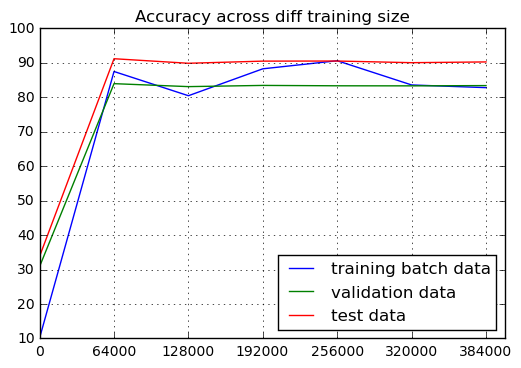

. Sample 10 Ranges are :  ['104832-104960', '48512-48640', '183488-183616', '44480-44608', '94528-94656', '17792-17920', '42368-42496', '9600-9728', '95680-95808', '169920-170048']


In [167]:
# PS: The right amount of regularisation should improve the accuracy. 
#If accuracy does not improve then then try reducing the beta 
run_NN(batch_size = 128, num_hidden = 1024, beta = 0.01,\
            overfitting_prevention_startegy_regularisation  = 'Yes',\
            overfitting_prevention_startegy_dropout  = 'No', num_steps = num_steps )

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Small Training Size @ SGD 
-----------------------------------------------------

In [20]:
# Run SGD with small training size
# See how it performs, compared to NN for the same data size
run_SGD( num_steps = num_steps , limit_train_size_to = 512 )


Initialized
Minibatch loss at step 0: 46.123348
Minibatch accuracy: 14.1%
Validation accuracy: 13.7%
Minibatch loss at step 500: 0.427420
Minibatch accuracy: 100.0%
Validation accuracy: 76.4%
Minibatch loss at step 1000: 0.282288
Minibatch accuracy: 100.0%
Validation accuracy: 77.2%
Minibatch loss at step 1500: 0.317578
Minibatch accuracy: 99.2%
Validation accuracy: 77.1%
Minibatch loss at step 2000: 0.247546
Minibatch accuracy: 100.0%
Validation accuracy: 77.2%
Minibatch loss at step 2500: 0.280649
Minibatch accuracy: 100.0%
Validation accuracy: 77.3%
Minibatch loss at step 3000: 0.317401
Minibatch accuracy: 99.2%
Validation accuracy: 77.1%
Test accuracy: 84.0%
Training time taken with stochastic gradient and tensorflow 0:00:14.538419


**Conclusion :** Extreme case of overfitting. Minibatch accuracy is 100% i.e perfectly predicts the train data indicating overfitting on the training data.

Small Training Size @ Regularised Neural Network
-----------------------------------------------------


batch_size =  128  num_hidden =  1024  beta =  0.01
no dropout
no dropout
no dropout
regularisation
Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -
Yes Regularisation
No Dropout
Initialisation complete 2017-01-17 23:26:34.274330
Initialized
Minibatch loss @ step 0: 3524.03 .Accuracy Minibatch / Validation : 7.0% / 27.9%
Minibatch loss @ step 500: 21.01 .Accuracy Minibatch / Validation : 100.0% / 76.7%
Minibatch loss @ step 1000: 0.45 .Accuracy Minibatch / Validation : 100.0% / 78.6%
Minibatch loss @ step 1500: 0.31 .Accuracy Minibatch / Validation : 100.0% / 78.4%
Minibatch loss @ step 2000: 0.26 .Accuracy Minibatch / Validation : 100.0% / 78.3%
Minibatch loss @ step 2500: 0.27 .Accuracy Minibatch / Validation : 100.0% / 78.6%
Minibatch loss @ step 3000: 0.28 .Accuracy Minibatch / Validation : 100.0% / 78.6%
Test accuracy: 85.8%
 Following training sets has been tried . Range Set Size 3
 Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken  0:02:11.2

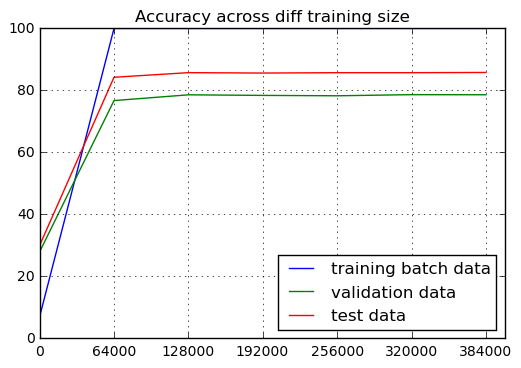

. Sample 10 Ranges are :  ['256-384', '128-256', '0-128']


In [168]:
run_NN(batch_size = 128, num_hidden = 1024, beta = 0.01,\
            overfitting_prevention_startegy_regularisation  = 'Yes',\
            overfitting_prevention_startegy_dropout  = 'No', num_steps = num_steps\
      , limit_train_size_to = 512)


Small Training Size @ No Regularised Neural Network
-----------------------------------------------------


batch_size =  128  num_hidden =  1024  beta =  0.01
no dropout
no dropout
no dropout
no regularisation
Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -
No Regularisation
No Dropout
Initialisation complete 2017-01-17 23:31:03.340140
Initialized
Minibatch loss @ step 0: 296.72 .Accuracy Minibatch / Validation : 9.4% / 25.0%
Minibatch loss @ step 500: 0.00 .Accuracy Minibatch / Validation : 100.0% / 75.5%
Minibatch loss @ step 1000: 0.00 .Accuracy Minibatch / Validation : 100.0% / 75.5%
Minibatch loss @ step 1500: 0.00 .Accuracy Minibatch / Validation : 100.0% / 75.5%
Minibatch loss @ step 2000: 0.00 .Accuracy Minibatch / Validation : 100.0% / 75.5%
Minibatch loss @ step 2500: 0.00 .Accuracy Minibatch / Validation : 100.0% / 75.5%
Minibatch loss @ step 3000: 0.00 .Accuracy Minibatch / Validation : 100.0% / 75.5%
Test accuracy: 82.8%
 Following training sets has been tried . Range Set Size 3
 Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken  0:02:18.0

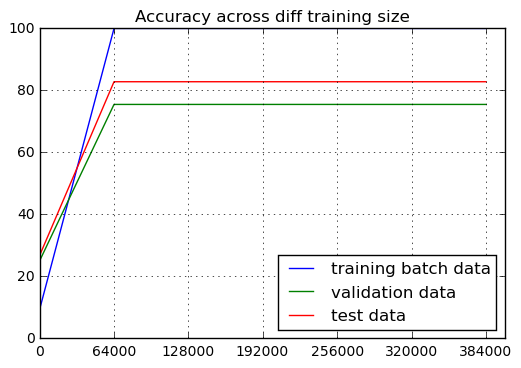

. Sample 10 Ranges are :  ['256-384', '128-256', '0-128']


In [169]:
run_NN(batch_size = 128, num_hidden = 1024, beta = 0.01,\
            overfitting_prevention_startegy_regularisation  = 'No',\
            overfitting_prevention_startegy_dropout  = 'No', num_steps = num_steps\
      , limit_train_size_to = 512)


Small Training Size @ No Regularised, Yes Drop out Neural Network
-----------------------------------------------------


batch_size =  128  num_hidden =  1024  beta =  0.01
dropout
no dropout
no dropout
no dropout
no regularisation
Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -
No Regularisation
Yes Dropout
Initialisation complete 2017-01-17 23:33:51.464817
Initialized
Minibatch loss @ step 0: 503.69 .Accuracy Minibatch / Validation : 9.4% / 32.8%
Minibatch loss @ step 500: 0.00 .Accuracy Minibatch / Validation : 100.0% / 76.5%
Minibatch loss @ step 1000: 0.00 .Accuracy Minibatch / Validation : 100.0% / 76.8%
Minibatch loss @ step 1500: 0.00 .Accuracy Minibatch / Validation : 100.0% / 77.2%
Minibatch loss @ step 2000: 0.00 .Accuracy Minibatch / Validation : 100.0% / 77.4%
Minibatch loss @ step 2500: 0.00 .Accuracy Minibatch / Validation : 100.0% / 77.5%
Minibatch loss @ step 3000: 0.00 .Accuracy Minibatch / Validation : 100.0% / 77.4%
Test accuracy: 85.0%
 Following training sets has been tried . Range Set Size 3
 Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken  

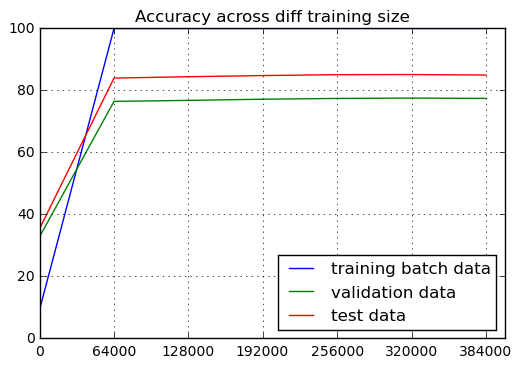

. Sample 10 Ranges are :  ['256-384', '128-256', '0-128']


In [170]:
run_NN(batch_size = 128, num_hidden = 1024, beta = 0.01,\
            overfitting_prevention_startegy_regularisation  = 'No',\
            overfitting_prevention_startegy_dropout  = 'Yes', num_steps = num_steps\
      , limit_train_size_to = 512)


Small Training Size @ Yes Regularised , Yes Dropout Neural Network
-----------------------------------------------------


batch_size =  128  num_hidden =  1024  beta =  0.01
dropout
no dropout
no dropout
no dropout
regularisation
Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -
Yes Regularisation
Yes Dropout
Initialisation complete 2017-01-17 23:38:56.984547
Initialized
Minibatch loss @ step 0: 3595.41 .Accuracy Minibatch / Validation : 12.5% / 24.6%
Minibatch loss @ step 500: 21.06 .Accuracy Minibatch / Validation : 100.0% / 77.2%
Minibatch loss @ step 1000: 0.49 .Accuracy Minibatch / Validation : 100.0% / 78.5%
Minibatch loss @ step 1500: 0.34 .Accuracy Minibatch / Validation : 100.0% / 78.3%
Minibatch loss @ step 2000: 0.28 .Accuracy Minibatch / Validation : 100.0% / 78.4%
Minibatch loss @ step 2500: 0.30 .Accuracy Minibatch / Validation : 100.0% / 78.8%
Minibatch loss @ step 3000: 0.31 .Accuracy Minibatch / Validation : 99.2% / 78.7%
Test accuracy: 85.9%
 Following training sets has been tried . Range Set Size 3
 Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken  

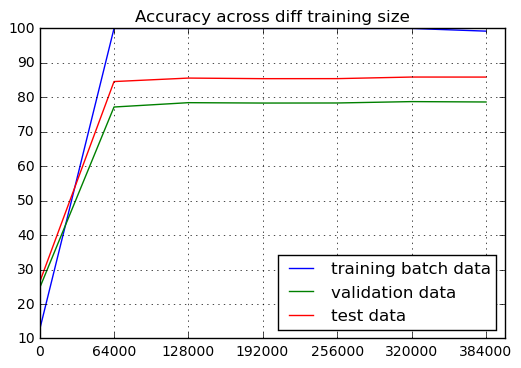

. Sample 10 Ranges are :  ['256-384', '128-256', '0-128']


In [171]:
run_NN(batch_size = 128, num_hidden = 1024, beta = 0.01,\
            overfitting_prevention_startegy_regularisation  = 'Yes',\
            overfitting_prevention_startegy_dropout  = 'Yes', num_steps = num_steps\
      , limit_train_size_to = 512)


**Conclusion : ** We observed that, when few train datasets (i.e 500) are provided, then the Minibatch accuracy is 100% across each steps, while the validation accuracy is 78.5%. This indicates the extreme case of overfitting, where our model is completely able to predict across training dataset with 100% correctness, however when faced with new data as in the validation set,  the performance significantly drops. This may be explained by the fact that  the only training set is ['256-384', '128-256', '0-128'] index data of the all available.  

Compare this to our earlier cases, where we used the full dataset and our training samples were 3000 different training examples, the minibatch accuracy was never vastly different to the validation accurayc and never greater than 89%, which meant that the model generated from the training was never overfitting. And that the train model also performed with fairly similar performance across train and validation set meant that the model was generic enough to work even for the unseen data.

In addition, we also observed that due to the overfitting model thus obtained our prediction accuracy in the real data i.e test data in fact performed poorly i.e a typical case of overfitting model.



---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

NN with Dropout - Yes, Regularisation - No  @ Full Data
--------------------------------------------

batch_size =  128  num_hidden =  1024  beta =  0.01
dropout
no dropout
no dropout
no dropout
no regularisation
Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -
No Regularisation
Yes Dropout
Initialisation complete 2017-01-17 23:42:54.907942
Initialized
Minibatch loss @ step 0: 461.60 .Accuracy Minibatch / Validation : 13.3% / 28.0%
Minibatch loss @ step 500: 45.67 .Accuracy Minibatch / Validation : 74.2% / 79.2%
Minibatch loss @ step 1000: 19.64 .Accuracy Minibatch / Validation : 71.9% / 79.1%
Minibatch loss @ step 1500: 20.14 .Accuracy Minibatch / Validation : 77.3% / 78.7%
Minibatch loss @ step 2000: 4.33 .Accuracy Minibatch / Validation : 75.8% / 79.8%
Minibatch loss @ step 2500: 5.46 .Accuracy Minibatch / Validation : 75.0% / 79.8%
Minibatch loss @ step 3000: 2.54 .Accuracy Minibatch / Validation : 75.8% / 79.5%
Test accuracy: 87.2%
 Following training sets has been tried . Range Set Size 3001
 Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken 

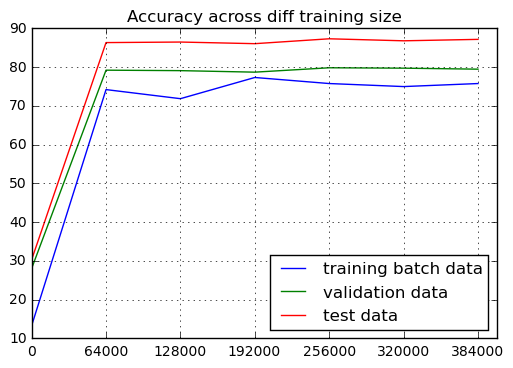

. Sample 10 Ranges are :  ['104832-104960', '48512-48640', '183488-183616', '44480-44608', '94528-94656', '17792-17920', '42368-42496', '9600-9728', '95680-95808', '169920-170048']


In [172]:
run_NN(batch_size = 128, num_hidden = 1024, beta = 0.01,\
            overfitting_prevention_startegy_regularisation  = 'No',\
            overfitting_prevention_startegy_dropout  = 'Yes', num_steps = num_steps\
      )

** Test what happens with the OVerfitting with drop out overfitting prevention strategy  **

*NN with Dropout - Yes, Regularisation - Yes @ Full Data*

batch_size =  128  num_hidden =  1024  beta =  0.01
dropout
no dropout
no dropout
no dropout
regularisation
Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -
Yes Regularisation
Yes Dropout
Initialisation complete 2017-01-17 23:48:47.338666
Initialized
Minibatch loss @ step 0: 3666.44 .Accuracy Minibatch / Validation : 8.6% / 25.5%
Minibatch loss @ step 500: 21.34 .Accuracy Minibatch / Validation : 85.2% / 83.7%
Minibatch loss @ step 1000: 1.04 .Accuracy Minibatch / Validation : 79.7% / 82.7%
Minibatch loss @ step 1500: 0.67 .Accuracy Minibatch / Validation : 85.2% / 83.1%
Minibatch loss @ step 2000: 0.67 .Accuracy Minibatch / Validation : 90.6% / 82.9%
Minibatch loss @ step 2500: 0.76 .Accuracy Minibatch / Validation : 83.6% / 83.2%
Minibatch loss @ step 3000: 0.84 .Accuracy Minibatch / Validation : 82.0% / 83.0%
Test accuracy: 89.8%
 Following training sets has been tried . Range Set Size 3001
 Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken  0:0

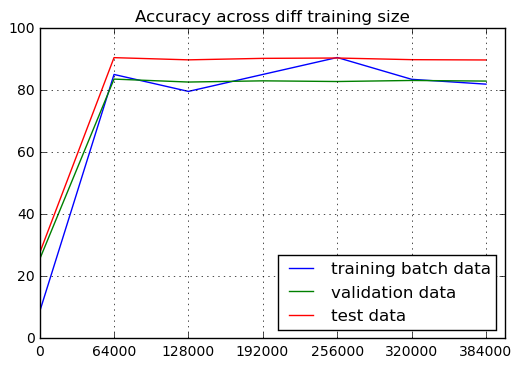

. Sample 10 Ranges are :  ['104832-104960', '48512-48640', '183488-183616', '44480-44608', '94528-94656', '17792-17920', '42368-42496', '9600-9728', '95680-95808', '169920-170048']


In [173]:
run_NN(batch_size = 128, num_hidden = 1024, beta = 0.01,\
            overfitting_prevention_startegy_regularisation  = 'Yes',\
            overfitting_prevention_startegy_dropout  = 'Yes', num_steps = num_steps\
      )

batch_size =  128  num_hidden =  1024  beta =  0.01
no dropout
no dropout
no dropout
regularisation
Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -
Yes Regularisation
No Dropout
Initialisation complete 2017-01-17 23:52:38.216992
Initialized
Minibatch loss @ step 0: 3519.76 .Accuracy Minibatch / Validation : 5.5% / 32.5%
Minibatch loss @ step 500: 21.21 .Accuracy Minibatch / Validation : 89.8% / 84.2%
Minibatch loss @ step 1000: 0.95 .Accuracy Minibatch / Validation : 81.2% / 83.2%
Minibatch loss @ step 1500: 0.58 .Accuracy Minibatch / Validation : 86.7% / 83.6%
Minibatch loss @ step 2000: 0.61 .Accuracy Minibatch / Validation : 90.6% / 83.4%
Minibatch loss @ step 2500: 0.72 .Accuracy Minibatch / Validation : 84.4% / 83.3%
Minibatch loss @ step 3000: 0.76 .Accuracy Minibatch / Validation : 80.5% / 83.4%
Test accuracy: 90.3%
 Following training sets has been tried . Range Set Size 3001
 Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken  0:02:08.0816

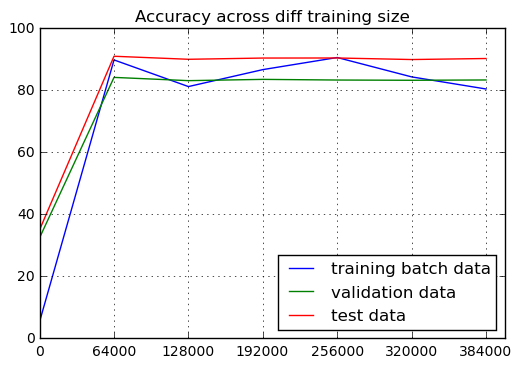

. Sample 10 Ranges are :  ['104832-104960', '48512-48640', '183488-183616', '44480-44608', '94528-94656', '17792-17920', '42368-42496', '9600-9728', '95680-95808', '169920-170048']


In [174]:
run_NN(batch_size = 128, num_hidden = 1024, beta = 0.01,\
            overfitting_prevention_startegy_regularisation  = 'Yes',\
            overfitting_prevention_startegy_dropout  = 'No', num_steps = num_steps\
      )

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [58]:
import datetime
import tensorflow as tf 

collect_accuracy_at_batch_interval_of = 500
# Training computation.
def loss_function_no_regularisation_1_hidden_layer(logits, tf_labels_train):
  #print('no regularisation')
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_labels_train))

def loss_function_with_regularisation_1_hidden_layer(logits, tf_labels_train, weights_for_hidden,weights,  beta):
  print('regularisation')
  regularisation_term = tf.nn.l2_loss(weights_for_hidden) + tf.nn.l2_loss(weights)
  return (( loss_function_no_regularisation(logits, tf_labels_train ) + beta * regularisation_term))

def forwardprop_no_dropout(tf_dataset,weights_for_hidden, biases_for_hidden ):
  #print('no dropout')  
  #return tf.nn.softmax(tf.nn.relu(tf.matmul(tf_dataset, weights_for_hidden ) + biases_for_hidden))
  return (tf.nn.relu(tf.matmul(tf_dataset, weights_for_hidden ) + biases_for_hidden))

# IMP: must not be done for validation or testing set
def forwardprop_dropout_for_training_data_only(tf_train_dataset,weights_for_hidden, biases_for_hidden, dropout_examples_by = 0.5 ):
  print('dropout')    
  return (tf.nn.dropout( forwardprop_no_dropout(tf_train_dataset,weights_for_hidden, biases_for_hidden ), dropout_examples_by ))

def forwardprop( dataset, weight, biases, overfitting_prevention_startegy_dropout  ):
    return  forwardprop_dropout_for_training_data_only( dataset, weight, biases ) \
                if overfitting_prevention_startegy_dropout == 'Yes' else\
            forwardprop_no_dropout( dataset, weight, biases )

def get_cost_function(logits, weights, tf_labels_train , beta_regularisation_coef, overfitting_prevention_startegy_regularisation ):
    if  overfitting_prevention_startegy_regularisation == 'Yes':
        print('Regularisation implemented')
        regularisation_term = tf.nn.l2_loss(weights['hidden_1']) + tf.nn.l2_loss(weights['hidden_2']) + tf.nn.l2_loss(weights['output'])  
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, tf_labels_train) ) + beta_regularisation_coef * regularisation_term
    else:
        #print('no Regularisation implemented')
        return  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, tf_labels_train) )

                               
def run_NN_custom(batch_size = 256, num_hidden_nodes_1 = 1024
                  ,num_hidden_nodes_2 = 12
                  ,beta_regularisation_coef = 0.1,\
            overfitting_prevention_startegy_regularisation  = 'No',\
            overfitting_prevention_startegy_dropout  = 'Yes',\
            learning_rate = 0.01, num_steps = 1001, limit_train_size_to  = '' ):
    print('batch_size = ',batch_size,' num_hidden_nodes_1 = ', num_hidden_nodes_1, ' beta = ', beta )
    graph = tf.Graph()
    with graph.as_default():

      # Input data. Unlike in earlier gradient descent, now we can take the whole data.
      # With gradient descent, we could not process all the input data and we had poor accuracy
      # For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tf_datasets = {
          'train' : tf.placeholder(tf.float32,  shape=(batch_size, image_size * image_size)),
          'valid' : tf.constant(valid_dataset) ,
          'test'  : tf.constant(test_dataset)
      }
      tf_labels = {
          'train' : tf.placeholder(tf.float32, shape=(batch_size, num_labels))           
      }
      
      # Variables.
      weights = {
          'hidden_1' : tf.Variable(tf.truncated_normal([ image_size * image_size , num_hidden_nodes_1])) ,
          'hidden_2' : tf.Variable(tf.truncated_normal([ num_hidden_nodes_1 , num_hidden_nodes_2])) ,
          'output'   : tf.Variable( tf.truncated_normal([num_hidden_nodes_2, num_labels]))
      }
        
      biases = {
          'hidden_1' : tf.Variable(tf.zeros([num_hidden_nodes_1])) ,
          'hidden_2' : tf.Variable(tf.zeros([num_hidden_nodes_2])) ,
          'output'   : tf.Variable(tf.zeros([num_labels]))
      }  
      
          
                #       if overfitting_prevention_startegy_dropout == 'Yes':            
                #         hidden_layers1 = forwardprop_dropout_for_training_data_only(\
                #                 tf_datasets['train'],weights['hidden_1'], biases['hidden_1'] , dropout_examples_by = 0.5 )
                #                                 #hidden_layers1_op = tf.nn.softmax(hidden1_layer_with_50_percent_examples_dropped_out)        
                #         hidden_layers2 = forwardprop_dropout_for_training_data_only(\
                #                         hidden_layers1, weights['hidden_2'], biases['hidden_2'], dropout_examples_by = 0.5 )

                #       else:
      hidden_layers1 ={
         'train' : forwardprop (tf_datasets['train'], weights['hidden_1'] , biases['hidden_1'] , overfitting_prevention_startegy_dropout) ,
         'valid' : forwardprop_no_dropout (tf_datasets['valid'], weights['hidden_1'],  biases['hidden_1']) ,
         'test'  : forwardprop_no_dropout (tf_datasets['test'],  weights['hidden_1'],  biases['hidden_1'])
      }  
    
      hidden_layers2 = {
        'train' : forwardprop (hidden_layers1['train'], weights['hidden_2'] , biases['hidden_2'],  overfitting_prevention_startegy_dropout) ,
        'valid' : forwardprop_no_dropout (hidden_layers1['valid'] ,weights['hidden_2'],  biases['hidden_2']) ,
        'test'  : forwardprop_no_dropout (hidden_layers1['test'] , weights['hidden_2'],  biases['hidden_2'])
     }             
     
      # Training computation.        
             
              #logits = tf.matmul(hidden_layers2, weights['output'] ) + biases['output']
                ## equivalent to
      logits = tf.add( tf.matmul(hidden_layers2['train'], weights['output'] ) , biases['output'] )    
      
              #e = tf.constant(value = 0.000001, shape = [num_labels])
              #logits = logits + e      
              #loss = tf.reduce_mean( -tf.reduce_sum( tf_labels['train'] * tf.log(tf.nn.softmax(logits)), reduction_indices = [1]) )
############# Loss Function
              #loss =  tf.reduce_mean( -tf.reduce_sum( tf_labels['train'] * (tf.log(tf.nn.softmax(logits) + 1e-10 )) ) )  ## avoid nan due to 0 * log(0)  
      
              #loss =  -tf.reduce_sum( tf_labels['train'] * (tf.log(tf.nn.softmax(logits) + 1e-10 )) )  ## avoid nan due to 0 * log(0)  
              #cost_function =   tf.log(logits + 1e-50)
              #tf.Print( cost_function, [cost_function] , "cost") ## debug runtime tensorflow

              #loss = tf.reduce_mean( -tf.reduce_sum( tf_labels['train'] * (tf.nn.log_softmax(logits)), reduction_indices = [1]) )

              # clippign is bad idea
              #loss = tf.reduce_mean( -tf.reduce_sum( tf_labels['train'] * tf.log(tf.clip_by_value(softmax , 1e-10,1.0) ), reduction_indices = [1]) )
              #loss =  tf.reduce_mean((logits, tf_labels['train']))
              #cost =  tf.reduce_mean((logits, tf_labels['train']))    # nan    
      #regularisation_term = tf.nn.l2_loss(weights['hidden_1']) + tf.nn.l2_loss(weights['hidden_2']) + tf.nn.l2_loss(weights['output'])  
    
                  #cost =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, tf_labels['train'])) 
      #cost =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, tf_labels['train'])) \
      #              + beta_regularisation_coef * regularisation_term
      cost = get_cost_function(logits, weights, tf_labels['train'] , beta_regularisation_coef,  overfitting_prevention_startegy_regularisation )
      

      #### Optimizer.
          #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(cost)  
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)  

      #### Predictions for the training, validation, and test data.
      predictions ={
          'train' : tf.nn.softmax(logits) ,
          'valid' : tf.nn.softmax(tf.matmul(hidden_layers2['valid'] , weights['output']) + biases['output']) ,
          'test'  : tf.nn.softmax(tf.matmul(hidden_layers2['test'] , weights['output']) + biases['output'])
      }
    
    print('Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -')
    print(overfitting_prevention_startegy_regularisation+' Regularisation')
    print(overfitting_prevention_startegy_dropout+' Dropout')
    print('Initialisation complete', datetime.datetime.now())
    #return graph

#def run_NN( num_steps = 3001, limit_train_size_to  = ''):    
    if limit_train_size_to == '':
        # consider all train data
        limit_train_size_to = train_dataset.shape[0]
    train_dataset_limited_to = train_dataset[0:limit_train_size_to,:]
    train_labels_limited_to = train_labels[0:limit_train_size_to,:]
    accuracy_all = np.ndarray(shape = (1 + num_steps/collect_accuracy_at_batch_interval_of, 4), dtype = np.float32)
    offset_range = set()

    start = datetime.datetime.now()
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print('')
      print("Initialized")        
      for step in range(num_steps):
                                # Pick an offset within the training data, which has been randomized.
                                # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_limited_to.shape[0] - batch_size)
        offset_range.add(str(offset) + '-' + str(offset + batch_size))
                                # Generate a minibatch.
        batch = {
            'data'   : train_dataset_limited_to[offset:(offset + batch_size), :] ,
            'labels' : train_labels_limited_to[offset:(offset + batch_size), :]
        }
        
                                # Prepare a dictionary telling the session where to feed the minibatch.
                                # The key of the dictionary is the placeholder node of the graph to be fed,
                                # and the value is the numpy array to feed to it.
        feed_dict = { tf_datasets['train'] : batch['data'], tf_labels['train'] : batch['labels'] }
        _, l, predictions_train = session.run([optimizer, cost, predictions['train']], feed_dict=feed_dict)        
        if (step % collect_accuracy_at_batch_interval_of == 0):
          print('Step @ ', step)            
                                          #print('    predictions size', (predictions['train'].shape), 'prediction for 5', predictions[train][0] )
                                          #print('    batch_labels size', (batch_labels.shape), 'batch_labels for 5', batch_labels[0] )
          accuracy_of = {
              'train' : accuracy( predictions_train, batch['labels'] ) ,
              'valid' : accuracy( predictions['valid'].eval(), valid_labels) ,
              'test'  : accuracy(predictions['test'].eval(), test_labels)               
          }      
        
          accuracy_all[step /collect_accuracy_at_batch_interval_of, :  ] = \
                        [ (step+1) * batch_size, accuracy_of['train'], accuracy_of['valid'], accuracy_of['test'] ]
          print("    Minibatch @ step %d. Loss: %.2f. Accuracy Minibatch / Validation / Test : %.1f%% / %.1f%% / %.1f%% " \
                        %(step, l, accuracy_of['train'], accuracy_of['valid'], accuracy_of['test']) )            
      session.close()  
      print("Final Test accuracy: %.1f%%" % accuracy_of['test'])
    
    print('')
    print(' Following training sets has been tried . Range Set Size',len(offset_range) )
    print(' Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken ', datetime.datetime.now() - start )
    print('. Sample 10 Ranges are : ', list(offset_range)[0:10] )
                                                        #print(accuracy_all)
                                                        #plot_accuracy(accuracy_all)
    

run_NN_custom(batch_size = 1280, num_hidden_nodes_1 = 2048\
                  ,num_hidden_nodes_2 = 1000
                  ,beta_regularisation_coef = 0.0001,\
            overfitting_prevention_startegy_regularisation  = 'Yes',\
            overfitting_prevention_startegy_dropout  = 'No',\
            learning_rate = 0.001, num_steps = 1501 )
print( 'Sucessfully Completed @ ', datetime.datetime.now() )


batch_size =  1280  num_hidden_nodes_1 =  2048  beta =  0.01
Regularisation implemented
Deep Neural Network with 1 Hidden layer with 1024 hidden nodes -
Yes Regularisation
No Dropout
Initialisation complete 2017-01-23 06:52:03.187061

Initialized
Step @  0
    Minibatch @ step 0. Loss: 1737.95. Accuracy Minibatch / Validation / Test : 7.5% / 9.6% / 9.3% 
Step @  500
    Minibatch @ step 500. Loss: 184.82. Accuracy Minibatch / Validation / Test : 84.7% / 82.9% / 89.7% 
Step @  1000
    Minibatch @ step 1000. Loss: 164.64. Accuracy Minibatch / Validation / Test : 87.4% / 84.5% / 91.1% 
Step @  1500
    Minibatch @ step 1500. Loss: 150.40. Accuracy Minibatch / Validation / Test : 90.8% / 85.3% / 91.4% 
Final Test accuracy: 91.4%

 Following training sets has been tried . Range Set Size 621
 Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken  0:26:26.637773
. Sample 10 Ranges are :  ['131840-133120', '149120-150400', '75840-77120', '34240-35520', '58560-59840', '91840-